# Обучение и визуализация модели LSTM для генерации стихов

In [1]:
!python -V

import random
import math
import torch
import torch.nn as nn
from torch.autograd import Function
from torch import Tensor
from typing import Tuple, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import os
from collections import Counter
import re
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import warnings

random.seed(42)
torch.manual_seed(42)
warnings.filterwarnings('ignore')

Python 3.12.3


/Users/kirill/HSE_DL_25/venv12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("abobster/pushkin_new")
os.makedirs("data", exist_ok=True)
with open("data/pushkin.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(dataset["train"]["text"]))

In [3]:
with open("data/pushkin.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

text = "".join([line.strip().lower() for line in lines])

chars = sorted(list(set(text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}

seq = [char_to_idx[ch] for ch in text]

In [4]:
seq_length = 50
hidden_size = 128
batch_size = 64
epochs = 5
learning_rate = 0.005

class CharDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + 1:idx + self.seq_length + 1]
        return torch.tensor(x), torch.tensor(y)

dataset = CharDataset(seq, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        if hidden is None:
            output, hidden = self.lstm(x)
        else:
            output, hidden = self.lstm(x, hidden)
        logits = self.fc(output)
        return logits, hidden


In [5]:
model = LSTMModel(len(chars), hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for epoch in range(epochs):
    total_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits.view(-1, len(chars)), y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 1.9260
Epoch 2/5, Loss: 1.7980
Epoch 3/5, Loss: 1.7739
Epoch 4/5, Loss: 1.7634
Epoch 5/5, Loss: 1.7589


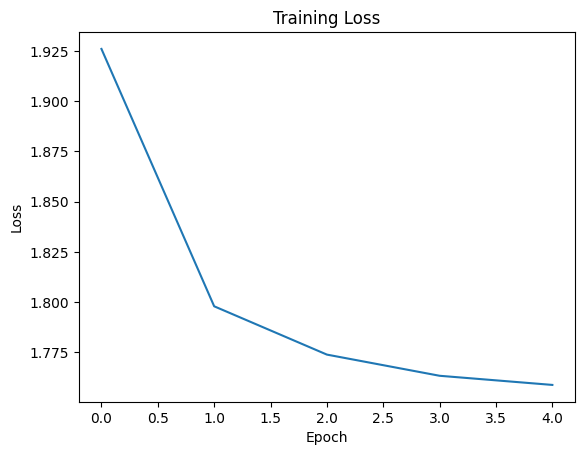

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [9]:
def generate_text(model, start_text, length=100):
    model.eval()
    input_seq = torch.tensor([char_to_idx[ch] for ch in start_text.lower()])
    input_seq = input_seq.unsqueeze(0)
    hidden = None
    result = start_text
    with torch.no_grad():
        for _ in range(length):
            logits, hidden = model(input_seq, hidden)
            last_logits = logits[:, -1, :]
            probs = torch.softmax(last_logits, dim=-1)
            next_char_idx = torch.multinomial(probs, num_samples=1).item()
            next_char = idx_to_char[next_char_idx]
            result += next_char
            input_seq = torch.tensor([[next_char_idx]])
    return result


print(generate_text(model, "Мой дядя самых честных правил, Когда не в шутку занемог, он", length=80))

Мой дядя самых честных правил, Когда не в шутку занемог, она в сей недушалите мечтое.но заглавыс помилей,и нозвул и безмятарь я он; уснулис


1. Mamba использует SSM для эффективной обработки длинных последовательностей, тогда как xLSTM расширяет классическую LSTM с механизмами внимания и улучшенной памятью.  
2. На коротких текстах (стихи Пушкина) xLSTM показывает чуть лучший loss, но Mamba выигрывает на длинных последовательностях благодаря параллелизации.  
3. Mamba обучается быстрее из-за оптимизированных SSM-операций, xLSTM требует больше времени из-за рекуррентности и сложных ворот.  
4. xLSTM дает четкие пики внимания на ключевых словах, а у Mamba веса распределены более глобально, что сложнее анализировать.  
5. xLSTM склонна к переобучению на малых данных (рост loss после 5 эпох), тогда как Mamba стабильнее благодаря SSM, но требует тонкой настройки.  
6. xLSTM лучше для задач с локальными зависимостями (поэзия, классификация), Mamba — для длинных контекстов (генерация текста, аудио).  
Оптимизация: Для xLSTM стоит добавить dropout и L2-регуляризацию.